In [1]:
#Imports
import pymysql
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

# Research questions 

How can we optimize customer segmentation by using the customer purchase history and the sequences of products purchased by the customer during the period represented in the data?

# Connect to the database

In [22]:
conn = pymysql.connect(host='learning-1000ml.c0zbrffehjje.us-east-2.rds.amazonaws.com', 
                       port=3306, 
                       user='root1000ml', 
                       passwd='IheartData', 
                       db = 'grocery_db')

## Product codes

In [23]:
products = pd.read_sql('select * from Products', conn)

In [4]:
products.head()

prod_id prod_code_10 prod_code_20 prod_code_30 prod_code_40
0  PRD0900001      CL00072     DEP00021       G00007       D00002
1  PRD0900002      CL00075     DEP00022       G00007       D00002
2  PRD0900003      CL00144     DEP00051       G00015       D00003
3  PRD0900004      CL00020     DEP00005       G00003       D00001
4  PRD0900005      CL00155     DEP00053       G00016       D00003

In [5]:
[products[col].nunique() for col in products.columns] 

[4997, 250, 90, 31, 9]

Here we have different levels of product:

1. Department level (Electronics & Office)

2. Product group level (Computers)

3. Product line level(Laptops)

4. Product class (2 in 1/ Touchscreen/ Gaming)

5. Product ( Lenovo XXX)

Is it possible (within time constraints) to use this data to create a hierarchy?

In [6]:
# Evaluate distribution wihtin hierarchies
class_products = products[products.columns[~products.columns.isin(['prod_id'])]].drop_duplicates()

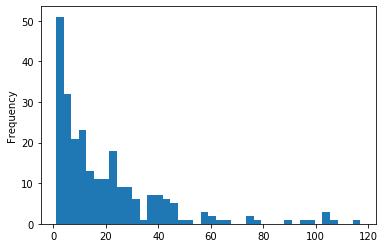

In [7]:
# Products per product class
products.groupby('prod_code_10').count()['prod_id'].plot(kind='hist', bins=40)

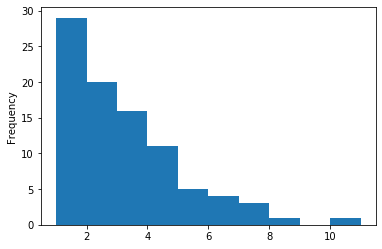

In [8]:
# Product classes per product line
products[['prod_code_20', 'prod_code_10']].drop_duplicates().groupby('prod_code_20').count()['prod_code_10'].plot(kind='hist')

In [9]:
# Product lines per product group 
products[['prod_code_30', 'prod_code_20']].drop_duplicates().groupby('prod_code_30').\
count().sort_values(by='prod_code_20', ascending=False)

prod_code_20
prod_code_30              
G00008                   7
G00010                   6
G00007                   6
G00004                   5
G00017                   5
G00023                   5
G00028                   5
G00003                   4
G00022                   4
G00012                   3
G00013                   3
G00016                   3
G00011                   3
G00006                   3
G00005                   3
G00018                   3
G00027                   2
G00024                   2
G00001                   2
G00019                   2
G00015                   2
G00014                   2
G00009                   2
G00020                   1
G00021                   1
G00002                   1
G00025                   1
G00026                   1
G00029                   1
G00030                   1
G00031                   1

In [10]:
# Product group per department
products[['prod_code_40', 'prod_code_30']].drop_duplicates().groupby('prod_code_40').count()

prod_code_30
prod_code_40              
D00001                   3
D00002                   6
D00003                   7
D00004                   4
D00005                   3
D00006                   2
D00007                   1
D00008                   3
D00009                   2

In [11]:
#Get the count of baskets
pd.read_sql('select count(*) from Baskets', conn)

count(*)
0    490982

In [12]:
# Get the count of products to the brand detail
pd.read_sql('select count(*) from Transactions', conn)

count(*)
0   3158469

In [13]:
#Query products grouped by basket_id and prod_code_10
baskets_df = pd.read_sql('select Transactions.basket_id, prod_code_10, Transactions.prod_id from Transactions \
                         left join Baskets on Transactions.basket_id = Baskets.basket_id\
                         left join Products on Transactions.prod_id = Products.prod_id;', conn)

In [ ]:
baskets_df.to_csv('baskets.csv', index=False)

In [3]:
baskets_df = pd.read_csv('baskets.csv')

In [6]:
#Count the number of apperances for prod_id for basket and prod_code_10
product_counts = baskets_df.groupby(['basket_id', 'prod_code_10']).count().reset_index()
product_counts

basket_id prod_code_10  prod_id
0        994100100000097      CL00043        1
1        994100100000097      CL00046        1
2        994100100000097      CL00058        1
3        994100100000097      CL00067        1
4        994100100000097      CL00070        2
...                  ...          ...      ...
2858999  994111700818351      CL00063        1
2859000  994111700818351      CL00101        1
2859001  994111700818351      CL00162        2
2859002  994111700818351      CL00222        1
2859003  994111700818612      CL00093        1

[2859004 rows x 3 columns]

In [8]:
# Pivot table to get the prod_code_10 in columns and the sum of those products to populate sparse matrix 
row_counts = pd.pivot_table(product_counts, columns='prod_code_10', index='basket_id', values='prod_id', fill_value=0)

In [9]:
# Check number of baskets
row_counts.shape[0]

490982

Ok, now we have a basket in each row with the count for every product type. Now let's see the distribution of these sums. 

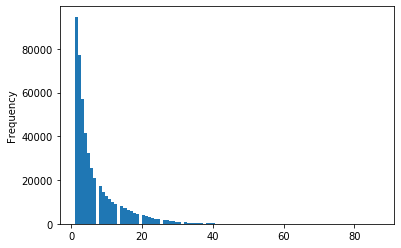

In [10]:
# Draw histogram of number of 
row_counts.sum(axis=1).plot(kind='hist', bins=100)

As expected we can see a Zipf distributed variable, hence, we are going to remove extremes of the distribution, just as we would do it with a BOW representation. For this, we will extract only the baskets with more than 4 items.

In [11]:
trim_row_counts = row_counts[row_counts.sum(axis=1)>=4]
trim_row_counts.shape

(261950, 250)

In [12]:
trim_row_counts.sum(axis=1).describe()

count    261950.000000
mean         10.452029
std           6.901226
min           4.000000
25%           5.000000
50%           8.000000
75%          14.000000
max          87.000000
dtype: float64

We end up with 261.950 baskets with 4 or more of the 250 product types available at the store. Let's cut down the number of products available for analysis.

In [13]:
trim_row_counts.sum(axis=0).describe()

count       250.000000
mean      10951.636000
std       14789.838262
min           0.000000
25%        1139.750000
50%        5789.500000
75%       15271.250000
max      110301.000000
dtype: float64

In [14]:
110301*0.05, 110301*0.95

(5515.05, 104785.95)

In [15]:
trim_row_counts = trim_row_counts[trim_row_counts.columns[(trim_row_counts.sum(axis=0) > 5500) &
                                        (trim_row_counts.sum(axis=0) < 110000)]]

In [38]:
trim_row_counts.shape

(261950, 126)

### Apply LDA 

In [16]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [17]:
# Helper function
def print_topics(model, feature_names, n_top_words):
    words = feature_names
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
 

In [18]:
count_data = trim_row_counts.values

In [63]:
# Iterate over multiple numbers of topics and get model
no_topics = np.linspace(4,10,4, dtype='int')

all_models = []

for num in no_topics:
    mod_dict = {}
    
    #Fit the data
    mod_dict['model'] = LDA(n_components=num, n_jobs=-1, verbose=0)
    mod_dict['model'].fit(count_data)
    
    #Get metrics
    mod_dict['perplexity'] = mod_dict['model'].perplexity(count_data) 
    
    #Append to list
    all_models.append(mod_dict)
    
    print(f'Finished LDA with {num} topics')

Finished LDA with 4 topics
Finished LDA with 6 topics
Finished LDA with 8 topics
Finished LDA with 10 topics


In [70]:
# See perplexity
all_perplexities = [mod['perplexity'] for mod in all_models]

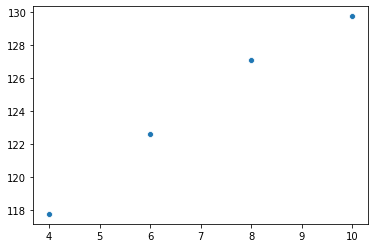

In [71]:
sns.scatterplot(x=no_topics, y=all_perplexities)

In [72]:
no_topics

array([ 4,  6,  8, 10])

In [73]:
# Extract the labels for each model
all_labels = [mod['model'].transform(count_data).argmax(axis=1) for mod in all_models] 

In [74]:
# Get sampled silhouette score
sil_scores = [silhouette_score(count_data, labels, sample_size=50000) for labels in all_labels]
sil_scores

[-0.023296057829527223,
 -0.03957342639711069,
 -0.03454221078623063,
 -0.04804150418103845]

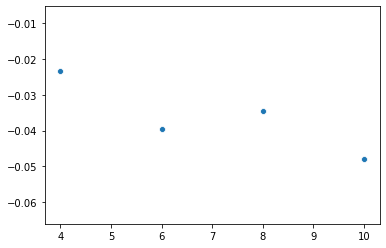

In [75]:
sns.scatterplot(y=sil_scores, x=no_topics)

#### What can I do with the topics? 

1. Cluster the baskets by topic and evaluate related information such as basket_tyoe, basket_price_sensitivity

2. Given cluster baskets, evaluate how is the spend related to the new basket clusters.

3. Cluster customers given the baskets cluster they usually buy.

4. Recommend products to customers given what they have in their baskets and their usual topic.